<a href="https://colab.research.google.com/github/Aji-25/airbnb-albany-price/blob/main/airbnb_listings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

import numpy as np
import pandas as pd

df = pd.read_csv('listings.csv', low_memory = False)
df.head()

Saving listings.csv to listings (3).csv


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2992450,https://www.airbnb.com/rooms/2992450,20250609011619,2025-06-09,city scrape,Luxury 2 bedroom apartment,The apartment is located in a quiet neighborho...,NaN,https://a0.muscache.com/pictures/44627226/0e72...,4621559,...,4.56,3.22,3.67,NaN,f,1,1,0,0,0.07
1,3820211,https://www.airbnb.com/rooms/3820211,20250609011619,2025-06-09,city scrape,Restored Precinct in Center Sq. w/Parking,"Cozy, cool little 1BR Apt in the heart Albany'...","Great restaurants, architecture, walking, peop...",https://a0.muscache.com/pictures/prohost-api/H...,19648678,...,4.81,4.83,4.78,NaN,f,4,4,0,0,2.34
2,5651579,https://www.airbnb.com/rooms/5651579,20250609011619,2025-06-09,city scrape,Large studio apt by Capital Center & ESP@,"Spacious studio with hardwood floors, fully eq...",The neighborhood is very eclectic. We have a v...,https://a0.muscache.com/pictures/b3fc42f3-6e5e...,29288920,...,4.88,4.76,4.64,NaN,f,2,1,1,0,3.02
3,6623339,https://www.airbnb.com/rooms/6623339,20250609011619,2025-06-09,city scrape,Center Sq. Loft in Converted Precinct w/ Parking,Large renovated 1 bedroom apartment in convert...,"Located in Albany's finest urban neighborhood,...",https://a0.muscache.com/pictures/prohost-api/H...,19648678,...,4.70,4.80,4.72,NaN,f,4,4,0,0,2.72
4,9005989,https://www.airbnb.com/rooms/9005989,20250609011619,2025-06-09,city scrape,"Studio in The heart of Center SQ, in Albany NY",(21 years of age or older ONLY) NON- SMOKING.....,"There are many shops, restaurants, bars, museu...",https://a0.muscache.com/pictures/d242a77e-437c...,17766924,...,4.93,4.87,4.77,NaN,f,1,1,0,0,5.76


In [ ]:
import re

keep_cols = ["price","neighbourhood_cleansed","room_type","latitude","longitude",
    "amenities","accommodates","bathrooms_text","bedrooms",
    "minimum_nights","number_of_reviews","review_scores_rating"]

df =df[keep_cols].copy()

df["price"] = df["price"].str.replace("$","",regex=False)
df["price"] = df["price"].str.replace(",","",regex=False)
df["price"] = pd.to_numeric(df["price"])

def parse_baths(x):
  if pd.isna(x): return np.nan
  m = re.search(r"(\d+(\.\d+)?)", str(x))
  return float(m.group(1)) if m else np.nan

df["bathrooms"] = df["bathrooms_text"].apply(parse_baths)
df = df.drop(columns=["bathrooms_text"])


df = df[(df["price"]>0) & (df["price"] < 1000)] #trimming the luxury places
df = df[(df["accommodates"] >= 1) & (df["accommodates"] <= 10)]
df = df[df["minimum_nights"]<=30] #avoiding longstay places

#removing duplicates

df = df.drop_duplicates()
df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"].astype(str).str.strip()
df["room_type"] = df["room_type"].astype(str).str.strip()

df.isnull().sum().sort_values(ascending=False)[:10]

,0
review_scores_rating,54
bathrooms,3
price,0
neighbourhood_cleansed,0
latitude,0
room_type,0
longitude,0
amenities,0
bedrooms,0
accommodates,0


In [ ]:
#creating log-price as linear model predicts better on log-price compared to normal, but at the end we'll still predict metrics on the original price itself

df["log_price"] = np.log1p(df["price"])

for col in ["bedrooms", "bathrooms", "review_scores_rating", "number_of_reviews"]:
  if col in df.columns:
    if col in ["bedrooms", "bathrooms"]:
      df[col] = df[col].fillna(df[col].median())
    else:
      df[col] = df[col].fillna(0.0)

df = df.dropna(subset=["latitude","longitude","room_type","neighbourhood_cleansed","log_price"])
df.shape

(393, 13)

In [ ]:
#picking the city center

def haversine(lat1, lon1, lat2, lon2):
  R = 6371.0
  p = np.radians(lat2-lat1)
  q = np.radians(lon2-lon1)
  a = np.sin(p/2)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(q/2)**2
  return 2 * R * np.arcsin(np.sqrt(a))

city_lat, city_lon = 42.6499, -73.7573
df["dist_city_km"] = haversine(df["latitude"], df["longitude"], city_lat, city_lon)
df[["latitude","longitude","dist_city_km"]].head()

,latitude,longitude,dist_city_km
0,42.65789,-73.75370,0.935956
1,42.65222,-73.76724,0.852875
2,42.64615,-73.75966,0.459488
3,42.65222,-73.76724,0.852875
4,42.65559,-73.76506,0.896131


In [ ]:
#making amenities_count

def parse_amenities_count(s):
  if pd.isna(s): return 0
  return s.count(",") + 1 if len(s)> 2 else 0

def has_flag(s, key):
  if pd.isna(s): return 0
  s = str(s).lower()
  k = str(key).lower()
  return 1 if k in s else 0

df["amenities_count"] = df["amenities"].apply(parse_amenities_count)

for key in ["wifi", "air conditioning", "kitchen", "washer", "elevator", "heating", "tv"]:
    df[f"amen_{key.replace(' ','_')}"] = df["amenities"].apply(lambda x: has_flag(x, key))

df = df.drop(columns=["amenities"])
df.head(3)


,price,neighbourhood_cleansed,room_type,latitude,longitude,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_rating,...,log_price,dist_city_km,amenities_count,amen_wifi,amen_air_conditioning,amen_kitchen,amen_washer,amen_elevator,amen_heating,amen_tv
0,70.0,THIRD WARD,Entire home/apt,42.65789,-73.75370,4,2.0,28,9,3.56,...,4.262680,0.935956,8,1,1,1,0,0,1,1
1,100.0,SIXTH WARD,Entire home/apt,42.65222,-73.76724,2,1.0,2,308,4.75,...,4.615121,0.852875,29,1,1,1,1,0,1,1
2,75.0,SECOND WARD,Entire home/apt,42.64615,-73.75966,2,0.0,2,371,4.51,...,4.330733,0.459488,33,1,1,1,1,0,1,1


In [ ]:
df["price_per_accomodate"] = df["price"] / df["accommodates"]
df["reviews_per_night_min"] = df["number_of_reviews"] / (df["minimum_nights"] +1)

In [ ]:
from sklearn.model_selection import train_test_split

target = "log_price"
categorical = ["room_type", "neighbourhood_cleansed"]

numeric = [
    "accommodates","bedrooms","bathrooms","minimum_nights",
    "number_of_reviews","review_scores_rating","dist_city_km",
    "amenities_count","amen_wifi","amen_air_conditioning","amen_kitchen",
    "amen_washer","amen_elevator","amen_heating","amen_tv",
    # "price_per_accommodate",            # REMOVE ← leakage: uses target
    "reviews_per_night_min"
]  # CHANGE: removed price_per_accommodate

# Keep the robustness before slicing

if "price" in df.columns and not np.issubdtype(df["price"].dtype, np.number):
    df["price"] = (df["price"].astype(str)
                              .str.replace(r"[\$,]", "", regex=True)
                              .astype(float))

for base in ["accommodates","minimum_nights","number_of_reviews",
             "review_scores_rating","bedrooms","bathrooms"]:
    if base in df.columns:
        df[base] = pd.to_numeric(df[base], errors="coerce")


if "reviews_per_night_min" not in df.columns:
    if all(c in df.columns for c in ["number_of_reviews","minimum_nights"]):
        df["reviews_per_night_min"] = df["number_of_reviews"].fillna(0) / (df["minimum_nights"].fillna(0) + 1)
        print("Created 'reviews_per_night_min'.")
    else:
        # Safe fallback if bases missing
        df["reviews_per_night_min"] = 0.0
        print("Set 'reviews_per_night_min' to 0.0 (missing bases).")

# Target
if "log_price" not in df.columns and "price" in df.columns:
    df["log_price"] = np.log1p(df["price"])

# Final guardrail before slicing
needed = categorical + numeric + [target]
have = [c for c in needed if c in df.columns]
missing = [c for c in needed if c not in df.columns]
if missing:
    print("Proceeding without missing columns:", missing)

df_use = df.dropna(subset=have)
X = df_use[[c for c in (categorical + numeric) if c in df_use.columns]].copy()
y = df_use[target].values

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Final features used:", X.columns.tolist())


Shapes: (275, 18) (59, 18) (59, 18)
Final features used: ['room_type', 'neighbourhood_cleansed', 'accommodates', 'bedrooms', 'bathrooms', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'dist_city_km', 'amenities_count', 'amen_wifi', 'amen_air_conditioning', 'amen_kitchen', 'amen_washer', 'amen_elevator', 'amen_heating', 'amen_tv', 'reviews_per_night_min']


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output = False)
num_transformer = StandardScaler()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, categorical),
        ("num", num_transformer, numeric)
    ]
)
preprocess


ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['room_type', 'neighbourhood_cleansed']),
                                ('num', StandardScaler(),
                                 ['accommodates', 'bedrooms', 'bathrooms',
                                  'minimum_nights', 'number_of_reviews',
                                  'review_scores_rating', 'dist_city_km',
                                  'amenities_count', 'amen_wifi',
                                  'amen_air_conditioning', 'amen_kitchen',
                                  'amen_washer', 'amen_elevator',
                                  'amen_heating', 'amen_tv',
                                  'reviews_per_night_min'])])

In [ ]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def eval_on_original(y_true_log, y_pred_log):
  y_true = np.expm1(y_true_log)
  y_pred = np.expm1(y_pred_log)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  return rmse, mae

from sklearn.pipeline import Pipeline
ols = Pipeline([
    ("prep", preprocess),
    ("lin", LinearRegression())
])

ols.fit(X_train, y_train)
y_val_pred_log = ols.predict(X_val)
r2_val_log = r2_score(y_val, y_val_pred_log)
rmse_val, mae_val = eval_on_original(y_val, y_val_pred_log)

print(f"[OLS] Val R² (log): {r2_val_log:.4f} | Val RMSE(orig): {rmse_val:.0f} | Val MAE(orig): {mae_val:.0f}")

ridge = Pipeline([
    ("prep", preprocess),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 13), cv=5))
])

ridge.fit(X_train, y_train)

y_val_ridge_log = ridge.predict(X_val)
r2_val_ridge = r2_score(y_val, y_val_ridge_log)
rmse_val_ridge, mae_val_ridge = eval_on_original(y_val, y_val_ridge_log)
print(f"[Ridge] Val R² (log): {r2_val_ridge:.4f} | RMSE(orig): {rmse_val_ridge:.0f} | MAE(orig): {mae_val_ridge:.0f}")

lasso = Pipeline([
    ("prep", preprocess),
    ("lasso", LassoCV(alphas=np.logspace(-3,1,10), cv=5, max_iter=5000, random_state=42))
])
lasso.fit(X_train, y_train)
y_val_lasso_log = lasso.predict(X_val)
r2_val_lasso = r2_score(y_val, y_val_lasso_log)
rmse_val_lasso, mae_val_lasso = eval_on_original(y_val, y_val_lasso_log)
print(f"[Lasso] Val R² (log): {r2_val_lasso:.4f} | RMSE(orig): {rmse_val_lasso:.0f} | MAE(orig): {mae_val_lasso:.0f}")


[OLS] Val R² (log): 0.6235 | Val RMSE(orig): 45 | Val MAE(orig): 29
[Ridge] Val R² (log): 0.6400 | RMSE(orig): 46 | MAE(orig): 29
[Lasso] Val R² (log): 0.6380 | RMSE(orig): 46 | MAE(orig): 29


In [ ]:
best_model = ridge  # or ols / lasso, based on Val performance above

y_test_pred_log = best_model.predict(X_test)
print("Test R² (log):", r2_score(y_test, y_test_pred_log))
rmse_test, mae_test = eval_on_original(y_test, y_test_pred_log)
print(f"Test RMSE(orig): {rmse_test:.0f} | Test MAE(orig): {mae_test:.0f}")


Test R² (log): 0.5712402383822572
Test RMSE(orig): 37 | Test MAE(orig): 27


In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Transform splits with the fitted preprocesser
X_train_s = preprocess.fit_transform(X_train)  # for torch, fit on TRAIN only
X_val_s   = preprocess.transform(X_val)
X_test_s  = preprocess.transform(X_test)

X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)  # log-price
y_val_t   = torch.tensor(y_val.reshape(-1,1),   dtype=torch.float32)
y_test_t  = torch.tensor(y_test.reshape(-1,1),  dtype=torch.float32)

n_features = X_train_t.shape[1]
weights = torch.randn((n_features, 1), requires_grad=True)
bias    = torch.randn(1, requires_grad=True)

lr = 0.05
epochs = 2000
weight_decay = 1e-3  # L2 regularization (Ridge-like)

train_hist, val_hist = [], []

for epoch in range(epochs):
    # forward (train)
    y_pred = X_train_t @ weights + bias
    mse = torch.mean((y_pred - y_train_t) ** 2)

    # L2 penalty
    l2 = (weights**2).sum()
    loss = mse + weight_decay * l2

    # validation
    with torch.inference_mode():
        y_val_pred = X_val_t @ weights + bias
        val_mse = torch.mean((y_val_pred - y_val_t) ** 2)

    loss.backward()
    with torch.no_grad():
        weights -= lr * weights.grad
        bias    -= lr * bias.grad
        weights.grad.zero_()
        bias.grad.zero_()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Train MSE(log): {mse.item():.4f} | Val MSE(log): {val_mse.item():.4f}")

    train_hist.append(mse.item())
    val_hist.append(val_mse.item())


Epoch    0 | Train MSE(log): 30.7405 | Val MSE(log): 35.1946
Epoch  200 | Train MSE(log): 0.1554 | Val MSE(log): 0.2667
Epoch  400 | Train MSE(log): 0.0959 | Val MSE(log): 0.1622
Epoch  600 | Train MSE(log): 0.0775 | Val MSE(log): 0.1296
Epoch  800 | Train MSE(log): 0.0704 | Val MSE(log): 0.1160
Epoch 1000 | Train MSE(log): 0.0674 | Val MSE(log): 0.1095
Epoch 1200 | Train MSE(log): 0.0660 | Val MSE(log): 0.1060
Epoch 1400 | Train MSE(log): 0.0654 | Val MSE(log): 0.1040
Epoch 1600 | Train MSE(log): 0.0651 | Val MSE(log): 0.1029
Epoch 1800 | Train MSE(log): 0.0649 | Val MSE(log): 0.1021


In [ ]:
def eval_on_original(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    return rmse, mae

with torch.inference_mode():
    y_test_pred_log_torch = (X_test_t @ weights + bias).numpy().reshape(-1)

r2_log_torch = r2_score(y_test, y_test_pred_log_torch)
rmse_torch, mae_torch = eval_on_original(y_test, y_test_pred_log_torch)
print(f"[Torch] Test R² (log): {r2_log_torch:.4f} | RMSE(orig): {rmse_torch:.0f} | MAE(orig): {mae_torch:.0f}")


[Torch] Test R² (log): 0.5808 | RMSE(orig): 38 | MAE(orig): 26


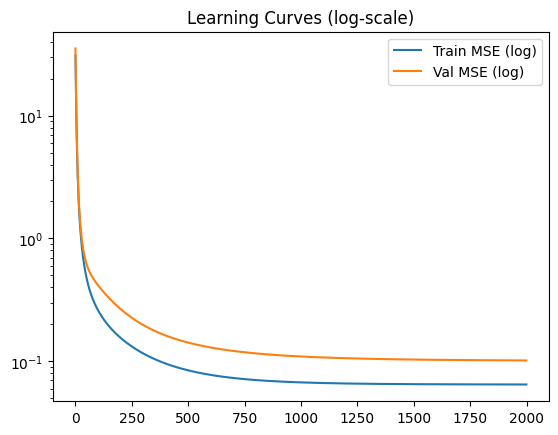

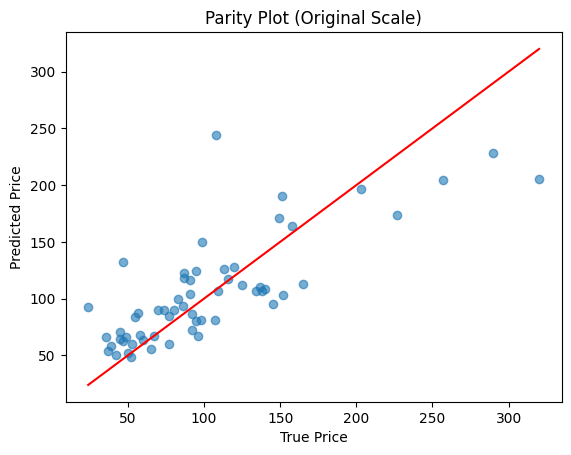

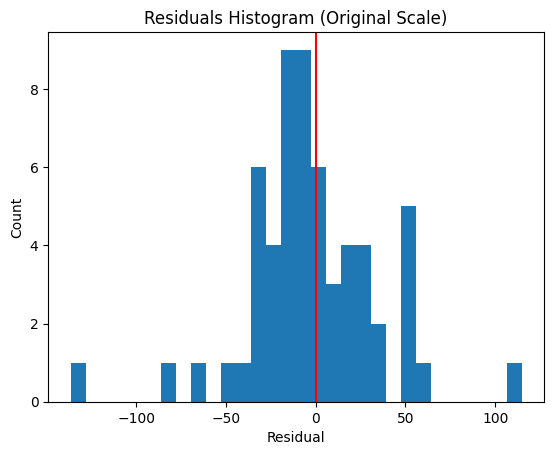

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Learning curves (log-loss)
plt.plot(train_hist, label="Train MSE (log)")
plt.plot(val_hist, label="Val MSE (log)")
plt.yscale("log")
plt.title("Learning Curves (log-scale)")
plt.legend(); plt.show()

# Parity (original scale)
y_test_true = np.expm1(y_test)
y_test_pred_orig = np.expm1(y_test_pred_log)  # from best sklearn model above

plt.scatter(y_test_true, y_test_pred_orig, alpha=0.6)
m = [y_test_true.min(), y_test_true.max()]
plt.plot(m, m, 'r-')
plt.xlabel("True Price"); plt.ylabel("Predicted Price")
plt.title("Parity Plot (Original Scale)"); plt.show()

# Residuals
resid = y_test_true - y_test_pred_orig
plt.hist(resid, bins=30)
plt.axvline(0, color='r')
plt.title("Residuals Histogram (Original Scale)")
plt.xlabel("Residual"); plt.ylabel("Count"); plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
import numpy as np

ridge_cv_pipe = Pipeline([
    ("prep", preprocess),
    ("ridge", RidgeCV(alphas=np.logspace(-3,3,13), cv=5))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ridge_cv_pipe, X, y, cv=kf, scoring="r2")
print("5‑Fold CV R² on log-price:", np.round(scores, 4), "Mean:", scores.mean())


5‑Fold CV R² on log-price: [0.5896 0.6281 0.5591 0.501  0.5905] Mean: 0.573658214573008


In [ ]:
def _haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    p = np.radians(lat2 - lat1)
    q = np.radians(lon2 - lon1)
    a = np.sin(p/2)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(q/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

_ALBANY_LAT, _ALBANY_LON = 42.6499, -73.7573

def _ensure_model_ready(best_model, X, y, preprocess):
    if 'best_model' not in globals():
        from sklearn.linear_model import RidgeCV
        from sklearn.pipeline import Pipeline
        print("best_model not found — training a quick Ridge pipeline on your current data…")
        return Pipeline([
            ("prep", preprocess),
            ("ridge", RidgeCV(alphas=np.logspace(-3,3,13), cv=5))
        ]).fit(X, y)
    return best_model

def predict_price(details, *, best_model=None, X=None, y=None, preprocess=None):
    import pandas as pd
    import numpy as np

    row = pd.DataFrame([details]).copy()

    if {"latitude","longitude"}.issubset(row.columns):
        row["dist_city_km"] = _haversine(row["latitude"], row["longitude"], _ALBANY_LAT, _ALBANY_LON)
    else:
        row["dist_city_km"] = 0.0

    categorical = ["room_type","neighbourhood_cleansed"]
    numeric = [
        "accommodates","bedrooms","bathrooms","minimum_nights",
        "number_of_reviews","review_scores_rating","dist_city_km",
        "amenities_count","amen_wifi","amen_air_conditioning","amen_kitchen",
        "amen_washer","amen_elevator","amen_heating","amen_tv",
        "reviews_per_night_min"
    ]

    for c in categorical:
        if c not in row.columns:
            row[c] = "Unknown"
    for n in numeric:
        if n not in row.columns:
            row[n] = 0.0

    if "amenities_count" in row.columns and (row["amenities_count"].iloc[0] == 0):
        amen_cols = [c for c in row.columns if c.startswith("amen_")]
        if amen_cols:
            row["amenities_count"] = row[amen_cols].sum(axis=1)

    mn = float(row["minimum_nights"].iloc[0]) if "minimum_nights" in row.columns else 0.0
    nr = float(row["number_of_reviews"].iloc[0]) if "number_of_reviews" in row.columns else 0.0
    row["reviews_per_night_min"] = nr / (mn + 1.0)

    mdl = _ensure_model_ready(best_model, X, y, preprocess)
    log_pred = mdl.predict(row)[0]
    price = np.expm1(log_pred)

    print("💡 Estimated nightly price: ${:.0f}".format(price))
    return price

In [ ]:
example_details = {
    # Location (ideally provide these for accurate distance)
    "latitude": 42.6526,
    "longitude": -73.7562,

    # Categorical
    "room_type": "Entire home/apt",
    "neighbourhood_cleansed": "Central Avenue",

    # Core size/features
    "accommodates": 4,
    "bedrooms": 2,
    "bathrooms": 1.0,
    "minimum_nights": 2,

    # Social proof
    "number_of_reviews": 35,
    "review_scores_rating": 95,   # (Inside Airbnb uses ~0–100)

    # Amenities (0/1 flags — add more if you like)
    "amen_wifi": 1,
    "amen_kitchen": 1,
    "amen_air_conditioning": 1,
    "amen_heating": 1,
    "amen_washer": 0,
    "amen_elevator": 0,
    "amen_tv": 1,

    # Optional: total count if you know it; else it will sum amen_* flags
    "amenities_count": 0
}

# IMPORTANT: pass in your objects so it can fallback-train if best_model is missing
predicted_price = predict_price(
    example_details,
    best_model=best_model if 'best_model' in globals() else None,
    X=X if 'X' in globals() else None,
    y=y if 'y' in globals() else None,
    preprocess=preprocess if 'preprocess' in globals() else None
)

💡 Estimated nightly price: $18
